In [1]:
"""
Este script realiza un análisis de componentes principales (PCA) en un conjunto de
imágenes de rostros para reconocimiento facial.

Las celdas de código están diseñadas para ser ejecutadas en Google Colab.
"""

#@title 1. Importar Librerías y Montar Google Drive
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from google.colab import drive

# Montar Google Drive para acceder a los archivos
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title 2. Cargar las Rutas de las Imágenes
# Definición de las rutas a las carpetas de imágenes de Google Drive
ruta_base = "/content/drive/MyDrive/ReporteFinal2/"
ruta_pca_faces = ruta_base + "PCA_faces/*.png"
ruta_recognition_faces = ruta_base + "recognition_faces/*.png"

# Cargar las rutas de los archivos en listas
pca_faces = glob(ruta_pca_faces)
recognition_faces = glob(ruta_recognition_faces)

# Imprimir la cantidad de imágenes en cada conjunto
print(f"Número de imágenes para entrenamiento (PCA): {len(pca_faces)}")
print(f"Número de imágenes para reconocimiento (Prueba): {len(recognition_faces)}")

Número de imágenes para entrenamiento (PCA): 150
Número de imágenes para reconocimiento (Prueba): 15


Dimensiones de cada imagen: 240x240 píxeles
Dimensiones de la matriz de datos M: (57600, 150)


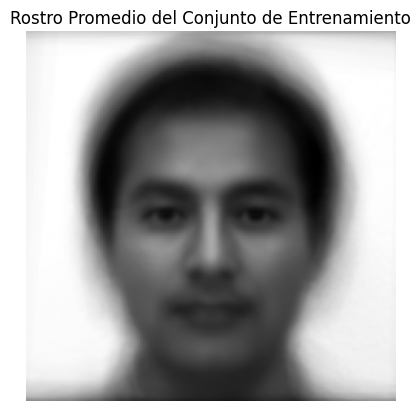

In [3]:
#@title 3. (Punto 1) Construir Matriz de Datos y Calcular Rostro Promedio

# Cargar la primera imagen para obtener las dimensiones
imagen_temporal = plt.imread(pca_faces[0])
dimensiones = imagen_temporal.shape
print(f"Dimensiones de cada imagen: {dimensiones[0]}x{dimensiones[1]} píxeles")

# Crear la matriz M que contendrá todas las imágenes como columnas
# Cada imagen se aplana en un vector de tamaño (altura x ancho)
M = np.zeros((dimensiones[0] * dimensiones[1], len(pca_faces)))

for i, ruta_imagen in enumerate(pca_faces):
    # Cargar la imagen y aplanarla en orden 'F' (por columnas)
    imagen = plt.imread(ruta_imagen)
    M[:, i] = imagen.flatten('F')

print(f"Dimensiones de la matriz de datos M: {M.shape}")

# Calcular el rostro promedio (la media de todas las columnas)
rostro_promedio_vec = np.mean(M, axis=1)

# Remodelar el vector promedio a las dimensiones originales de la imagen para visualizarlo
rostro_promedio_img = np.reshape(rostro_promedio_vec, (dimensiones[0], dimensiones[1]), 'F')

# Mostrar el rostro promedio
plt.imshow(rostro_promedio_img, cmap='gray')
plt.title("Rostro Promedio del Conjunto de Entrenamiento")
plt.axis('off')
plt.show()

Dimensiones de la matriz U (Eigenfaces): (57600, 150)


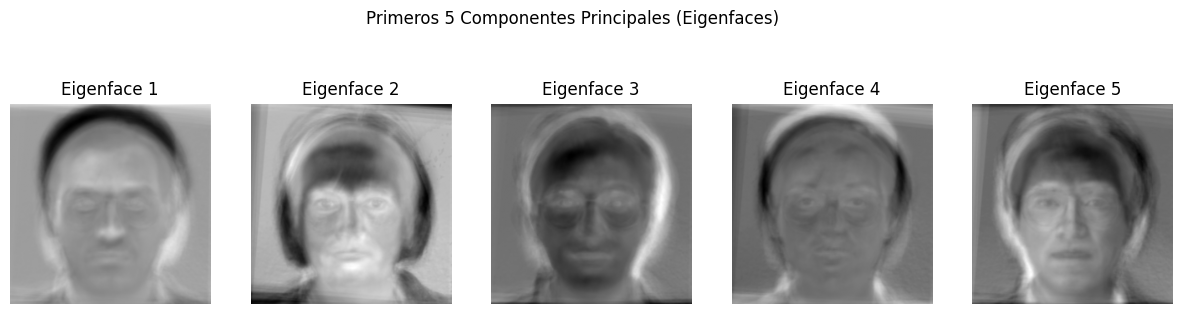

In [4]:
#@title 4. (Punto 2) Calcular Componentes Principales (Eigenfaces)

# Centrar los datos restando el rostro promedio
# M_centrada = M - rostro_promedio_vec.reshape(-1, 1) # Forma alternativa usando broadcasting
rostro_promedio_matriz = np.tile(rostro_promedio_vec, (len(pca_faces), 1)).T
M_centrada = M - rostro_promedio_matriz

# Calcular la Descomposición de Valores Singulares (SVD)
# U contendrá los componentes principales (eigenfaces)
# Se utiliza full_matrices=False para eficiencia
U, S, VT = np.linalg.svd(M_centrada, full_matrices=False)

print(f"Dimensiones de la matriz U (Eigenfaces): {U.shape}")

# Mostrar los primeros 5 componentes principales (eigenfaces)
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    # Remodelar la columna de U para visualizarla como imagen
    eigenface = np.reshape(U[:, i], (dimensiones[0], dimensiones[1]), 'F')
    axes[i].imshow(eigenface, cmap='gray')
    axes[i].set_title(f"Eigenface {i+1}")
    axes[i].axis('off')
plt.suptitle("Primeros 5 Componentes Principales (Eigenfaces)")
plt.show()

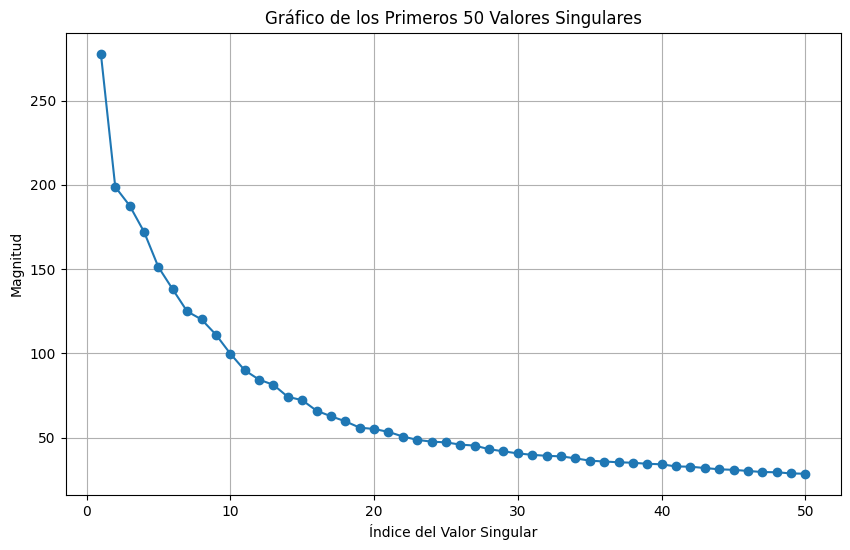

In [5]:
#@title 5. (Punto 2) Graficar los Primeros 50 Valores Singulares

# Graficar los primeros 50 valores singulares
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), S[:50], 'o-')
plt.title("Gráfico de los Primeros 50 Valores Singulares")
plt.xlabel("Índice del Valor Singular")
plt.ylabel("Magnitud")
plt.grid(True)
plt.show()

In [6]:
#@title 6. Función para Reconocimiento Facial

def reconocer_rostro(ruta_imagen_prueba, U, rostro_promedio_vec, M_entrenamiento, k_componentes):
    """
    Reconoce un rostro de prueba comparándolo con un conjunto de entrenamiento.
    """
    # Usar solo los primeros 'k' componentes
    Uk = U[:, :k_componentes]

    # Proyección de las imágenes de entrenamiento
    proyecciones_entrenamiento = Uk.T @ (M_entrenamiento - rostro_promedio_vec.reshape(-1, 1))

    # Cargar la imagen de prueba
    imagen_prueba_raw = plt.imread(ruta_imagen_prueba)

    # 1. Manejo de múltiples canales (como el canal Alfa/transparencia)
    if imagen_prueba_raw.ndim > 2:
        imagen_procesada = imagen_prueba_raw[:, :, 0]
    else:
        imagen_procesada = imagen_prueba_raw

    # 2. Asegurar que la imagen sea de tipo float y esté normalizada en el rango [0, 1]
    imagen_procesada = imagen_procesada.astype(np.float32)
    if imagen_procesada.max() > 1.0:
        imagen_procesada = imagen_procesada / 255.0

    # Aplanar y centrar el vector de la imagen de prueba ya procesada
    vector_prueba = imagen_procesada.flatten('F')
    vector_prueba_centrado = vector_prueba - rostro_promedio_vec

    # Proyectar la imagen de prueba
    proyeccion_prueba = Uk.T @ vector_prueba_centrado

    # Calcular las distancias euclidianas a todas las proyecciones de entrenamiento
    distancias = np.linalg.norm(proyecciones_entrenamiento - proyeccion_prueba.reshape(-1, 1), axis=0)

    # Encontrar el índice de la distancia mínima
    indice_mas_cercano = np.argmin(distancias)

    return indice_mas_cercano

In [7]:
#@title 7. Evaluar la Precisión del Reconocimiento

def evaluar_precision(k_componentes):
    """
    Calcula el número de reconocimientos correctos para un 'k' dado.
    """
    reconocimientos_correctos = 0

    # --- INICIO DE LA CORRECCIÓN ---
    # Extraemos el ID del sujeto (el número) dividiendo por el guion '-'
    ids_sujetos_pca = [ruta.split('/')[-1].split('.')[0].split('-')[1] for ruta in pca_faces]

    for ruta_prueba in recognition_faces:
        id_sujeto_prueba = ruta_prueba.split('/')[-1].split('.')[0].split('-')[1]
    # --- FIN DE LA CORRECCIÓN ---

        indice_predicho = reconocer_rostro(ruta_prueba, U, rostro_promedio_vec, M, k_componentes)
        id_sujeto_predicho = ids_sujetos_pca[indice_predicho]

        if id_sujeto_prueba == id_sujeto_predicho:
            reconocimientos_correctos += 1

    return reconocimientos_correctos

# Buscar el número de componentes para 7 y 12 aciertos
k_para_7 = -1
k_para_12 = -1
es_posible_todos = False

max_componentes = len(pca_faces) # El número máximo de componentes es 150

for k in range(1, max_componentes + 1):
    aciertos = evaluar_precision(k)

    if aciertos >= 7 and k_para_7 == -1:
        k_para_7 = k
    if aciertos >= 12 and k_para_12 == -1:
        k_para_12 = k
    if aciertos == 15:
        es_posible_todos = True

    # Imprimir progreso para no esperar hasta el final
    if k % 10 == 0 or k == 1:
      print(f"Con k={k}, aciertos = {aciertos}/15")


print("\n--- Resultados de Reconocimiento ---")
print(f"Componentes necesarios para reconocer 7/15 rostros: {k_para_7}")
print(f"Componentes necesarios para reconocer 12/15 rostros: {k_para_12}")
print(f"¿Es posible reconocer los 15/15 rostros?: {'Sí' if es_posible_todos else 'No'}")

Con k=1, aciertos = 2/15
Con k=10, aciertos = 15/15
Con k=20, aciertos = 15/15
Con k=30, aciertos = 15/15
Con k=40, aciertos = 15/15
Con k=50, aciertos = 15/15
Con k=60, aciertos = 15/15
Con k=70, aciertos = 15/15
Con k=80, aciertos = 15/15
Con k=90, aciertos = 15/15
Con k=100, aciertos = 15/15
Con k=110, aciertos = 15/15
Con k=120, aciertos = 15/15
Con k=130, aciertos = 15/15
Con k=140, aciertos = 15/15
Con k=150, aciertos = 15/15

--- Resultados de Reconocimiento ---
Componentes necesarios para reconocer 7/15 rostros: 3
Componentes necesarios para reconocer 12/15 rostros: 5
¿Es posible reconocer los 15/15 rostros?: Sí


In [8]:
#@title Celda para listar los archivos de prueba
print("--- Archivos disponibles en 'recognition_faces' ---")
for ruta in recognition_faces:
    print(ruta.split('/')[-1])

--- Archivos disponibles en 'recognition_faces' ---
wink-12.png
wink-05.png
wink-02.png
wink-07.png
wink-10.png
wink-13.png
wink-04.png
wink-11.png
wink-06.png
wink-14.png
wink-09.png
wink-03.png
wink-01.png
wink-08.png
wink-15.png


In [9]:
#@title 8. (Punto 4) Reconstruir la imagen "wink_11.png"

#se define una funcion para la tarea de reconstruir imagenes
def reconstruir_imagen(ruta_imagen, U, rostro_promedio_vec, k_valores, dimensiones):
    """
    Reconstruye una imagen usando un número variable de componentes principales.
    """
    # Cargar la imagen
    imagen_raw = plt.imread(ruta_imagen)

    # --- INICIO DE LA CORRECCIÓN ---
    # Si la imagen tiene más de 2 dimensiones (ej: canal alfa),
    # nos quedamos solo con el primer canal, que es el de la escala de grises.
    if imagen_raw.ndim > 2:
        imagen = imagen_raw[:, :, 0]
    else:
        imagen = imagen_raw
    # --- FIN DE LA CORRECCIÓN ---

    # Aplanar y centrar el vector
    vector = imagen.flatten('F')
    vector_centrado = vector - rostro_promedio_vec

    # Graficar la imagen original
    fig, axes = plt.subplots(1, len(k_valores) + 1, figsize=(20, 5))
    axes[0].imshow(imagen, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Reconstruir y graficar para cada valor de k
    for i, k in enumerate(k_valores):
        Uk = U[:, :k]
        proyeccion = Uk.T @ vector_centrado
        reconstruccion_vec = Uk @ proyeccion + rostro_promedio_vec
        reconstruccion_img = np.reshape(reconstruccion_vec, (dimensiones[0], dimensiones[1]), 'F')

        axes[i+1].imshow(reconstruccion_img, cmap='gray')
        axes[i+1].set_title(f"k = {k}")
        axes[i+1].axis('off')

    plt.show()

Reconstrucción de 'wink-11.png'


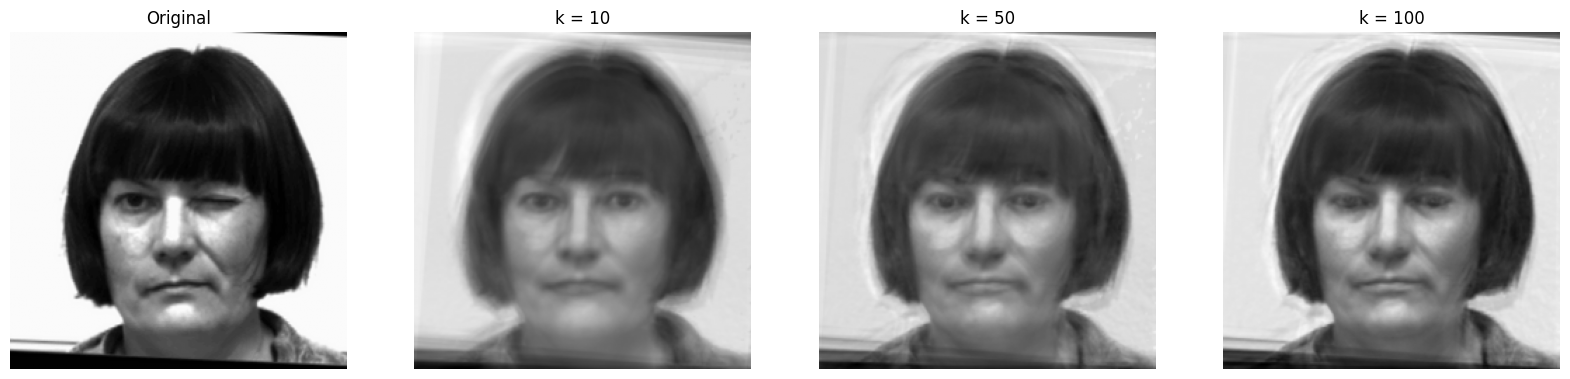

In [10]:
# Se procede a reconstruir la imagen winki-11.png utilizando la funcion reconstruir_imagen definida en la celda anterior
nombre_archivo_wink = "wink-11.png" # <--- nombre de archivo cambiado con el nombre del archivo encontrado en la "Celda para listar los archivos de prueba", es wink-11.png no wink_11.png

try:
    # Buscar la ruta completa de la imagen
    ruta_wink = [r for r in recognition_faces if nombre_archivo_wink in r][0]
    componentes_a_probar = [10, 50, 100]

    print(f"Reconstrucción de '{nombre_archivo_wink}'")

    # Verificar que la variable 'dimensiones' esté definida
    if 'dimensiones' not in locals():
        imagen_temporal = plt.imread(pca_faces[0])
        dimensiones = imagen_temporal.shape

    reconstruir_imagen(ruta_wink, U, rostro_promedio_vec, componentes_a_probar, dimensiones)

except IndexError:
    print(f"Error: No se pudo encontrar el archivo '{nombre_archivo_wink}'. Asegúrate de que el nombre sea correcto y esté en la lista.")

Reconstrucción de 'mi_foto_gris_240x240_2.png'


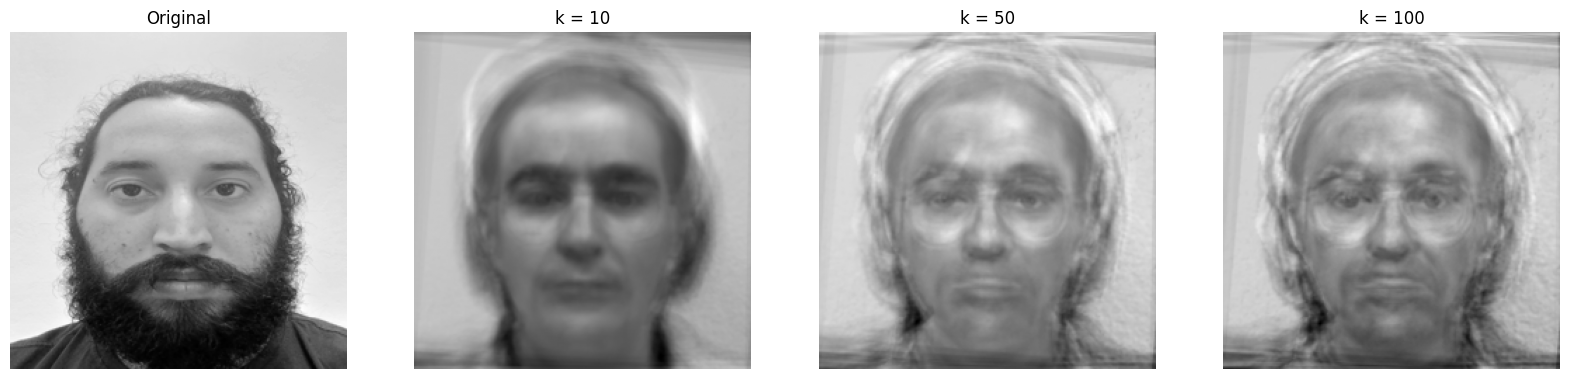

In [11]:
#@title 9. (Punto 4) Reconstruir foto propia

# --- TAREAS PREVIAS AL PUNTO 4 ---
# Subir foto propia (240x240, gris) a la carpeta de Drive.
# Asegurarse que nombre_de_mi_foto tenga el mismo nombre que "nombre_de_mi_foto"
nombre_de_mi_foto = "mi_foto_gris_240x240_2.png"
ruta_mi_foto = ruta_base + nombre_de_mi_foto

# Componentes a usar para la reconstrucción
componentes_a_probar = [10, 50, 100]

try:
    # --- Procesamiento Previo de Imagen Propia ---
    # Se abre con PIL para asegurar que sea un solo canal (escala de grises)
    img = Image.open(ruta_mi_foto).convert('L')
    # Se convierte a numpy array y se normaliza a [0, 1]
    mi_foto_array = np.array(img)
    if mi_foto_array.max() > 1.0:
        mi_foto_array = mi_foto_array / 255.0

    # Se guarda una versión temporal procesada para usar con la función
    ruta_temporal_mi_foto = "/content/mi_foto_procesada.png"
    plt.imsave(ruta_temporal_mi_foto, mi_foto_array, cmap='gray')

    # --- Reconstrucción ---
    print(f"Reconstrucción de '{nombre_de_mi_foto}'")

    # Asegúrarse de que la variable 'dimensiones' esté definida
    if 'dimensiones' not in locals():
        imagen_temporal = plt.imread(pca_faces[0])
        dimensiones = imagen_temporal.shape

    reconstruir_imagen(ruta_temporal_mi_foto, U, rostro_promedio_vec, componentes_a_probar, dimensiones)

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{ruta_mi_foto}'.")
    print("Por favor, asegúrate de que el archivo exista en tu Drive y el nombre sea correcto.")

Buscando el rostro más similar en el conjunto de entrenamiento...


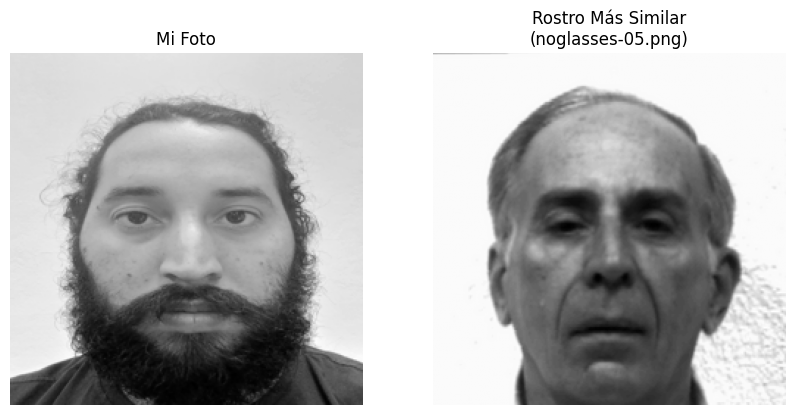

In [12]:
#@title 10. (Punto 5) Encontrar el Rostro Más Similar a mi Foto

print("Buscando el rostro más similar en el conjunto de entrenamiento...")

try:
    # Usamos la máxima cantidad de componentes para la mejor precisión
    # Llama a la función de reconocimiento con la ruta de tu mi foto procesada en la celda 9
    indice_similar = reconocer_rostro(ruta_temporal_mi_foto, U, rostro_promedio_vec, M, max_componentes)

    # Cargar y mostrar mi foto y la más similar para compararlas
    mi_foto_display = plt.imread(ruta_temporal_mi_foto)
    ruta_similar = pca_faces[indice_similar]
    foto_similar_display = plt.imread(ruta_similar)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(mi_foto_display, cmap='gray')
    axes[0].set_title("Mi Foto")
    axes[0].axis('off')

    axes[1].imshow(foto_similar_display, cmap='gray')
    axes[1].set_title(f"Rostro Más Similar\n({ruta_similar.split('/')[-1]})")
    axes[1].axis('off')

    plt.show()

except NameError:
    print("\nError: Parece que la variable 'ruta_temporal_mi_foto' no existe.")
    print("Asegúrate de haber ejecutado la Celda 9 correctamente antes de correr esta celda.")